In [1]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 37.2 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import sys
!{sys.executable} -m pip install nltk

In [3]:
!pip install sacremoses

     |████████████████████████████████| 880 kB 2.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0c79c263d0f997b1bd560b8065695ebcc4a99e427cbaae5a667f2ea0ab11eb33
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [4]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 3.5 MB/s 


In [5]:
!pip install torchtext==0.9.0

# After running this cell, you'll have to restart the runtime. After restarting the runtime do not run this cell again

     |████████████████████████████████| 7.1 MB 2.7 MB/s 
     |████████████████████████████████| 735.5 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchtext.legacy import data
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler
import nlpaug.augmenter.word as naw
import gc
import re,nltk
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

torch.manual_seed(1)
print("Imported")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Imported


In [7]:
#set processing device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
train_path = './train.tsv'
test_path = './test.tsv'
val_path = './valid.tsv'

In [9]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

### True and Fake News Distribution

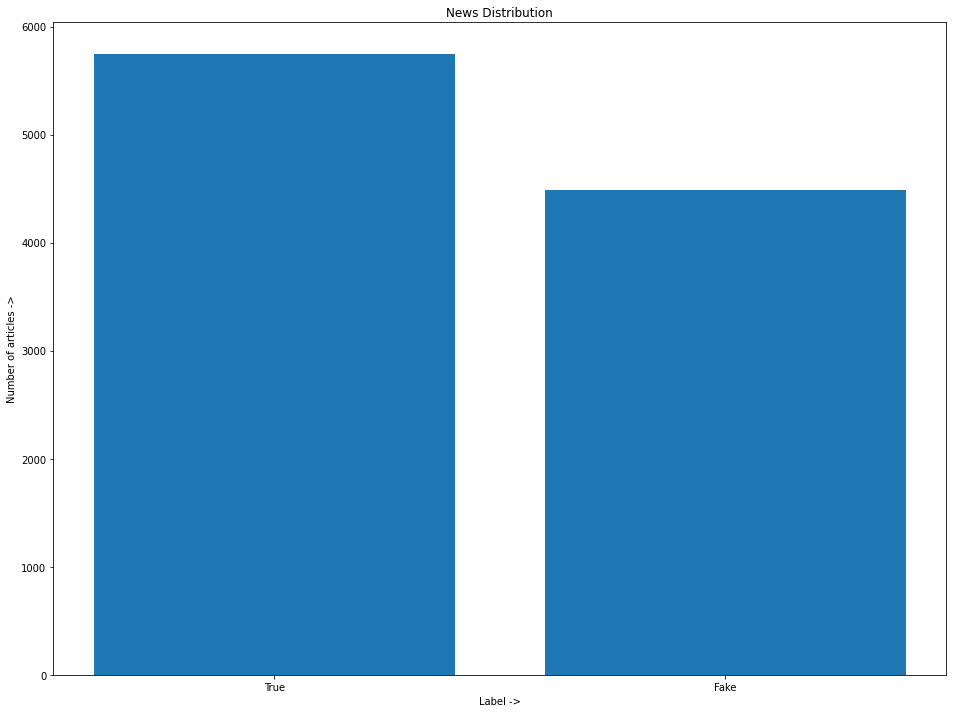

In [10]:
def news_distribution():
    train_df = pd.read_csv(train_path, sep="\t", header=None)
    train = train_df.values

    count_true = 0
    count_false = 0

    for article in train:
        if article[1] == 'false' or article[1] == 'pants-fire' or article[1] == 'barely-true':
          count_false += 1
        else: count_true += 1

    plt.figure(2, figsize=[16, 12])
    plt.title("News Distribution")
    plt.xlabel("Label ->")
    plt.ylabel("Number of articles ->")
    plt.bar(range(2), [count_true, count_false], tick_label=["True", "Fake"])

news_distribution()

### Building Dataset

In [13]:
def to_onehot(a):
    a_cat = [0]*len(a)
    for i in range(len(a)):
        if a[i]=='true':
            a_cat[i] = 1
        elif a[i]=='mostly-true':
            a_cat[i] = 1
        elif a[i]=='half-true':
            a_cat[i] = 1
        elif a[i]=='barely-true':
            a_cat[i] = 0
        elif a[i]=='false':
            a_cat[i] = 0
        elif a[i]=='pants-fire':
            a_cat[i] = 0
        else:
            print('Incorrect label')
    return a_cat

def build_dataset_train(statements,labels,length):
    count=Counter()
    # Clean the sentences
    for i in range(len(statements)):
        statements[i]=re.sub('\d','0',statements[i])
    #Count the appearance of words. Remove word if appeared only once in set
    for i,sentence in enumerate(statements):
        statements[i]=[]
        for word in nltk.word_tokenize(sentence):
            word=word.lower()
            count.update([word])
            statements[i].append(word)
    count={key:value for key,value in count.items() if value>1}
    
    count=sorted(count,reverse=True, key=lambda key:count[key])
    count+=['_padding','_unknown']

    word_to_idx={word:index for index,word in enumerate(count)}
    idx_to_word={index:word for index,word in enumerate(count)}
    
    #Tokenize sentences
    for i,sentence in enumerate(statements):
        statements[i]=[word_to_idx[word] if word in count else 0 for word in sentence ]
    
    
    
    train_statements=padding(statements,length)
    train_label=np.array(labels)
    
    print("Done build...train")
    return train_statements,train_label,word_to_idx,idx_to_word

def build_dataset_test(statements,labels,length,word_to_idx):
    # Clean the sentences
    for i in range(len(statements)):
        statements[i]=re.sub('\d','0',statements[i])
        statements[i]=[word_to_idx[word.lower()] if word.lower() in word_to_idx else 0 for word in nltk.word_tokenize(statements[i]) ]

    test_statements=padding(statements,length)
    test_label=np.array(labels)
    print("Done build...test")
    return test_statements,test_label


def padding(statements, length):
    array=np.zeros((len(statements),length),dtype=int)
    for i,indexes in enumerate(statements):
        if len(indexes)!=0:
            array[i,-len(indexes):]=np.array(indexes)[:length]
    return array
    
# Augmenting Train Data using Back Translation
def augment_text_data(data):
    augmented_data = []
    
    # English-German-English Translation
    back_translation_aug = naw.BackTranslationAug(
        from_model_name='facebook/wmt19-en-de', 
        to_model_name='facebook/wmt19-de-en'
    )

    count = 1
    for article in data:
        augmented_data.append(article)
        if article[1] == "true" or article[1] == "false" or article[1] == "pants-fire":
          augmented_sentence = back_translation_aug.augment(article[2])
          article[2] = augmented_sentence
          augmented_data.append(article)
        print(f"Progress: ${count} augmented")
        count += 1

    return augmented_data

    
def get_liar_dataset():
    train_df = pd.read_csv(train_path, sep="\t", header=None)
    test_df = pd.read_csv(test_path, sep="\t", header=None)
    val_df = pd.read_csv(val_path, sep="\t", header=None)

    train = train_df.values
    test = test_df.values
    val = val_df.values

    train = augment_text_data(train)
    
    labels = {'train':train[:,1], 'test':test[:,1], 'val':val[:,1]}
    statements = {'train':train[:,2], 'test':test[:,2], 'val':val[:,2]}
    subjects = {'train':train[:,3], 'test':test[:,3], 'val':val[:,3]}
    speaker = {'train':train[:,4], 'test':test[:,4], 'val':val[:,4]}
    job = {'train':train[:,5], 'test':test[:,5], 'val':val[:,5]}
    state = {'train':train[:,6], 'test':test[:,6], 'val':val[:,6]}
    affiliation = {'train':train[:,7], 'test':test[:,7], 'val':val[:,7]}
    
    length=20
    labels_onehot = {'train':to_onehot(labels['train']), 'test':to_onehot(labels['test']), 'val':to_onehot(labels['val'])}
    print("Building training set")
    train_dataset,train_label,word_to_idx,idx_to_word = build_dataset_train(statements['train'],labels_onehot['train'],length)
    print("Building valid set")
    val_dataset,val_label = build_dataset_test(statements['val'],labels_onehot['val'],length,word_to_idx)
    print("Building testing set")
    test_dataset,test_label = build_dataset_test(statements['test'],labels_onehot['test'],length,word_to_idx)

    return train_dataset, val_dataset, test_dataset,train_label,val_label,test_label,word_to_idx,idx_to_word

def create_wordcloud():
    train_df = pd.read_csv(train_path, sep="\t", header=None)
    test_df = pd.read_csv(test_path, sep="\t", header=None)

    train = train_df.values
    test = test_df.values

    true_words = []
    fake_words = []
    for article in train:
      if article[1] == 'false' or article[1] == 'pants-fire' or article[1] == 'barely-true':
        fake_words.append(article[2])
      else: true_words.append(article[2])

    true_all_words = ' '.join(true_words)
    false_all_words = ' '.join(fake_words)

    print("True Articles WordCloud")
    wordcloud_real = WordCloud(background_color='white',
                        width= 800, height= 500,
                        max_font_size = 180,
                        collocations = False).generate(true_all_words)
    plt.figure(1, figsize=(10,7))
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    print("\nFake Articles WordCloud")
    wordcloud_false = WordCloud(background_color='white',
                        width= 800, height= 500,
                        max_font_size = 180,
                        collocations = False).generate(false_all_words)

    plt.figure(2, figsize=(10,7))
    plt.imshow(wordcloud_false, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
train_dataset, val_dataset, test_dataset,train_label,val_label,test_label,word_to_idx,idx_to_word = get_liar_dataset()


Progress: $1 augmented
Progress: $2 augmented
Progress: $3 augmented
Progress: $4 augmented
Progress: $5 augmented
Progress: $6 augmented
Progress: $7 augmented
Progress: $8 augmented
Progress: $9 augmented
Progress: $10 augmented
Progress: $11 augmented
Progress: $12 augmented
Progress: $13 augmented
Progress: $14 augmented
Progress: $15 augmented
Progress: $16 augmented
Progress: $17 augmented
Progress: $18 augmented
Progress: $19 augmented
Progress: $20 augmented
Progress: $21 augmented
Progress: $22 augmented
Progress: $23 augmented
Progress: $24 augmented
Progress: $25 augmented
Progress: $26 augmented
Progress: $27 augmented
Progress: $28 augmented
Progress: $29 augmented
Progress: $30 augmented
Progress: $31 augmented
Progress: $32 augmented
Progress: $33 augmented
Progress: $34 augmented
Progress: $35 augmented
Progress: $36 augmented
Progress: $37 augmented
Progress: $38 augmented
Progress: $39 augmented
Progress: $40 augmented
Progress: $41 augmented
Progress: $42 augmented
P

### Wordclouds showing common words in True and Fake articles

In [ ]:
from wordcloud import WordCloud

create_wordcloud()

### Calculating Credibility of News Creators

{'dwayne-bohac': 0.0, 'scott-surovell': 100.0, 'barack-obama': 73.15573770491804, 'blog-posting': 13.559322033898304, 'charlie-crist': 64.28571428571429, 'robin-vos': 63.63636363636363, 'republican-party-texas': 50.0, 'oregon-lottery': 50.0, 'duey-stroebel': 100.0, 'robert-menendez': 72.72727272727273, 'bernie-s': 72.72727272727273, 'mitt-romney': 59.09090909090909, 'doonesbury': 100.0, 'george-will': 54.166666666666664, 'national-republican-congressional-committee': 34.78260869565217, 'gwen-moore': 58.82352941176471, 'jack-lew': 50.0, 'dennis-richardson': 50.0, 'eric-bolling': 100.0, 'hillary-clinton': 73.64016736401673, 'greater-wisconsin-political-fund': 25.0, 'planned-parenthood-action-fund': 0.0, 'nancy-pelosi': 60.86956521739131, 'ted-nugent': 33.33333333333333, 'pamela-geller': 50.0, 'peter-kinder': 66.66666666666666, 'nicholas-kettle': 0.0, 'shelley-moore-capito': 0.0, 'rick-scott': 61.73913043478261, 'tom-cotton': 36.36363636363637, 'ted-cruz': 34.40860215053764, 'lee-leffingw

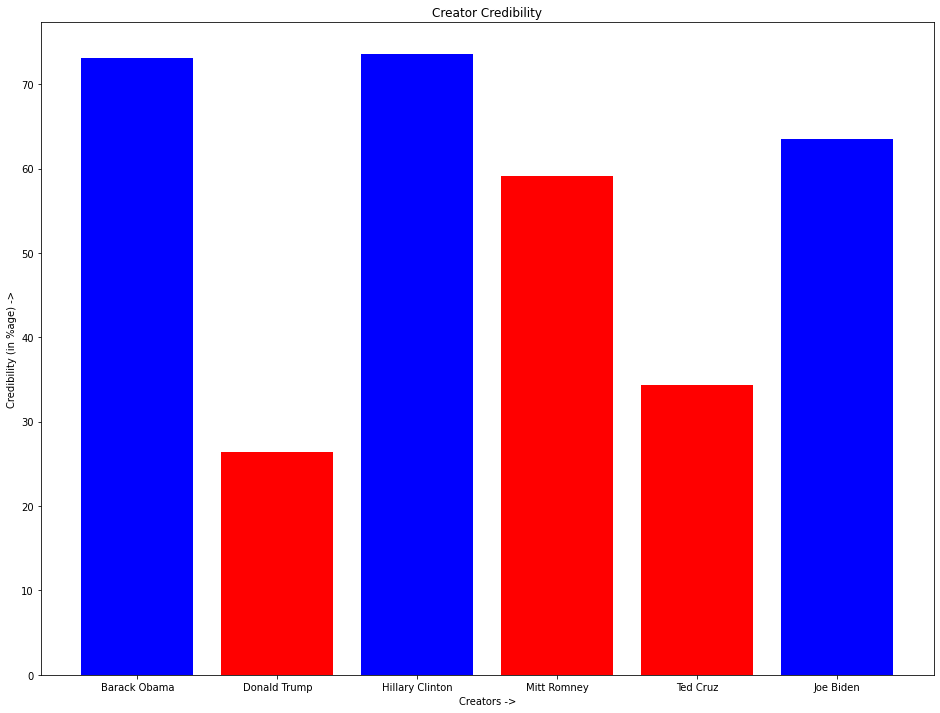

In [20]:
def calc_credibility(articles):
    true_count = 0
    for cred in articles:
      if cred == 'true' or cred == 'half-true' or cred == 'mostly-true':
        true_count += 1

    return true_count/len(articles)

def creator_credibility():
    train_df = pd.read_csv(train_path, sep="\t", header=None)

    train = train_df.values

    # Creating a dictionary with all the unique sources as keys
    creators = {}
    for article in train:
      if article[4] in creators:
        pass
      else:
        creators[article[4]] = []

    for article in train:
      creators[article[4]].append(article[1])

    creator_cred = {}
    for key, value in creators.items():
      creator_cred[key] = calc_credibility(value) * 100

    print(creator_cred)
    print("Number of creators: ", len(creator_cred.keys()))

    plt.figure(3, figsize=[16, 12])
    plt.title("Creator Credibility")
    plt.xlabel("Creators ->")
    plt.ylabel("Credibility (in %age) ->")
    plt.bar(range(6), [
                       creator_cred['barack-obama'],
                       creator_cred['donald-trump'],
                       creator_cred['hillary-clinton'],
                       creator_cred['mitt-romney'],
                       creator_cred['ted-cruz'],
                       creator_cred['joe-biden'], 
                       ], tick_label=[
                                      "Barack Obama",
                                      "Donald Trump",
                                      "Hillary Clinton",
                                      "Mitt Romney",
                                      "Ted Cruz",
                                      "Joe Biden"
                       ], color=['blue', 'red', 'blue', 'red', 'red', 'blue'])
      

creator_credibility()

### Calculating Credibility of News by Different Political Parties

Republican: 50.18901489882144% Democrat: 66.21702637889688%


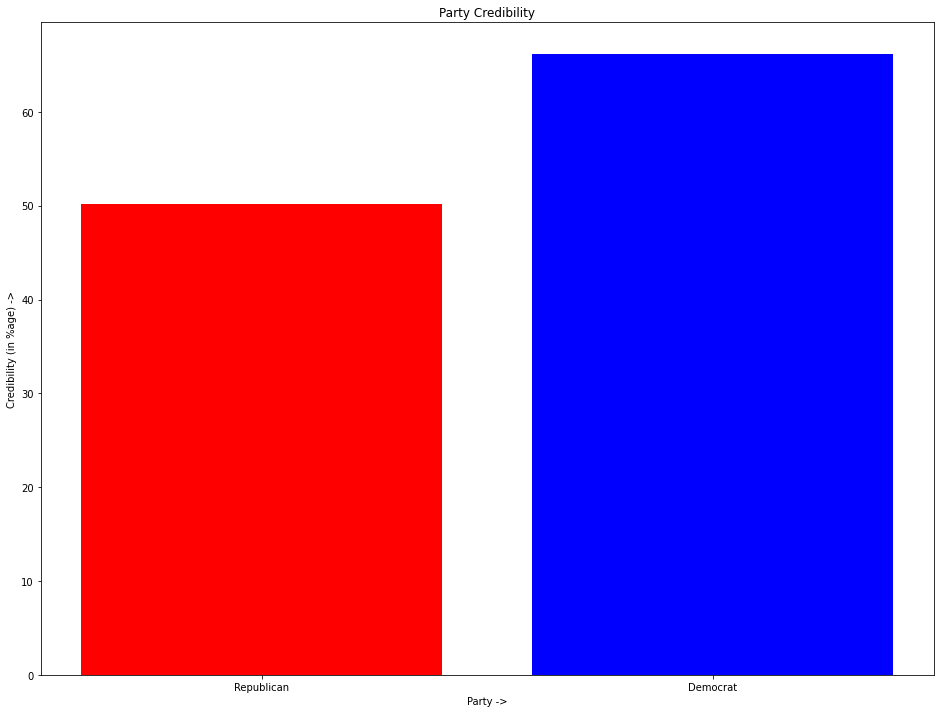

In [21]:
def party_credibility():
    train_df = pd.read_csv(train_path, sep="\t", header=None)

    train = train_df.values

    # Creating a dictionary with all the unique political parties as keys
    parties = {}
    for article in train:
      if article[7] in parties:
        pass
      else:
        parties[article[7]] = []

    for article in train:
      parties[article[7]].append(article[1])

    party_cred = {}
    for key, value in parties.items():
      party_cred[key] = calc_credibility(value) * 100

    print("Republican: " + str(party_cred['republican']) + "%", "Democrat: " + str(party_cred['democrat']) + "%")

    plt.figure(4, figsize=[16, 12])
    plt.title("Party Credibility")
    plt.xlabel("Party ->")
    plt.ylabel("Credibility (in %age) ->")
    plt.bar(range(2), [party_cred['republican'], party_cred['democrat']], tick_label=["Republican", "Democrat"], color=['red', 'blue'])

party_credibility()

### Calculating Credibility of Various News Subjects

{'abortion': 54.7244094488189, 'energy': 52.617801047120416, 'history': 50.864197530864196, 'job-accomplishments': 58.02047781569966, 'foreign-policy': 50.530785562632694, 'health-care': 47.07446808510639, 'economy': 62.822719449225474, 'jobs': 59.91561181434599, 'education': 64.01098901098901, 'candidates-biography': 51.454823889739664, 'ethics': 55.00000000000001, 'message-machine-2014': 37.5, 'voting-record': 50.505050505050505, 'elections': 56.34266886326195, 'new-hampshire-2012': 58.730158730158735, 'poverty': 65.1685393258427, 'state-budget': 56.896551724137936, 'federal-budget': 58.46774193548387, 'financial-regulation': 57.291666666666664, 'water': 60.37735849056604, 'bankruptcy': 73.33333333333333, 'population': 66.0, 'income': 65.92178770949721, 'corporations': 61.42857142857143, 'taxes': 56.53923541247485, 'message-machine': 53.8860103626943, 'crime': 59.64125560538116, 'diversity': 54.65116279069767, 'homeland-security': 60.550458715596335, 'terrorism': 48.28767123287671, '

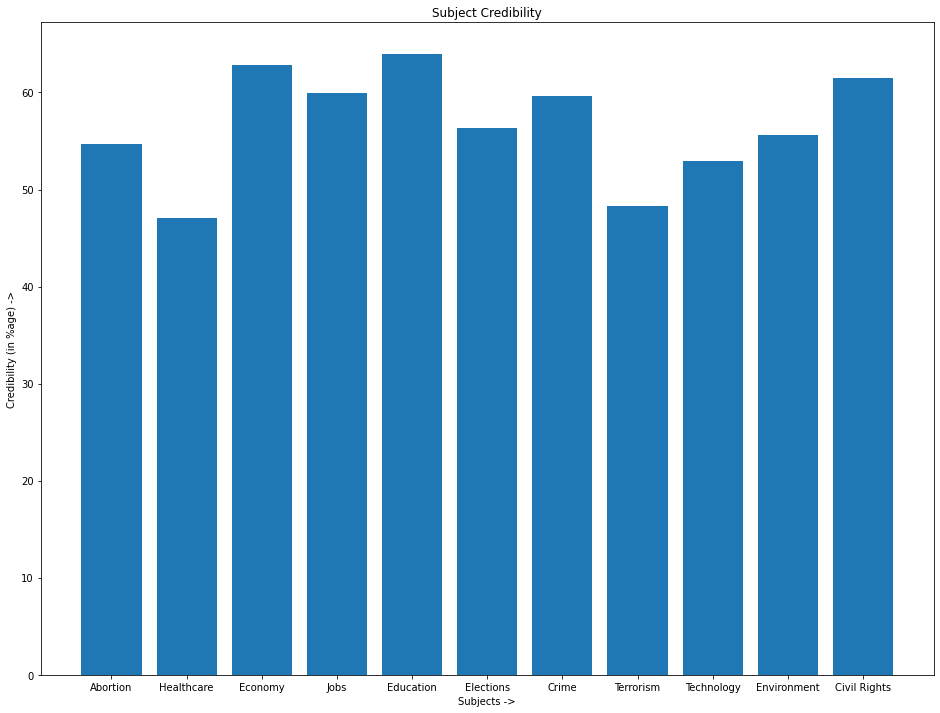

In [22]:
def subject_credibility():
    train_df = pd.read_csv(train_path, sep="\t", header=None)

    train = train_df.values

    # Creating a dictionary with all the unique sources as keys
    subjects = {}
    for article in train:
      if isinstance(article[3], str):
        each_sub = article[3].split(",")
        for sub in each_sub:
          if sub in subjects:
            pass
          else:
            subjects[sub] = []

    for article in train:
      if isinstance(article[3], str):
        each_sub = article[3].split(",")
        for sub in each_sub:
          subjects[sub].append(article[1])

    subject_cred = {}
    for key, value in subjects.items():
      subject_cred[key] = calc_credibility(value) * 100

    print(subject_cred)
    print("Number of subjects: ", len(subject_cred.keys()))

    plt.figure(5, figsize=[16, 12])
    plt.title("Subject Credibility")
    plt.xlabel("Subjects ->")
    plt.ylabel("Credibility (in %age) ->")
    plt.bar(range(11), [
                       subject_cred['abortion'],
                       subject_cred['health-care'],
                       subject_cred['economy'],
                       subject_cred['jobs'],
                       subject_cred['education'],
                       subject_cred['elections'], 
                       subject_cred['crime'],
                       subject_cred['terrorism'],
                       subject_cred['technology'],
                       subject_cred['environment'],
                       subject_cred['civil-rights'],
                       ], tick_label=[
                                      "Abortion",
                                      "Healthcare",
                                      "Economy",
                                      "Jobs",
                                      "Education",
                                      "Elections",
                                      "Crime",
                                      "Terrorism",
                                      "Technology",
                                      "Environment",
                                      "Civil Rights"
                       ])
      

subject_credibility()

### Loading Train, Val and Test Data

In [ ]:
#Turning into Tensor Dataset
batch_size=20
train_data=TensorDataset(torch.from_numpy(train_dataset),torch.from_numpy(train_label))
val_data=TensorDataset(torch.from_numpy(val_dataset),torch.from_numpy(val_label))
test_data=TensorDataset(torch.from_numpy(test_dataset),torch.from_numpy(test_label))
train_loader=DataLoader(train_data,shuffle=False,batch_size=batch_size, drop_last=True)
val_loader=DataLoader(val_data,shuffle=False,batch_size=batch_size, drop_last=True)
test_loader=DataLoader(test_data,shuffle=False,batch_size=batch_size, drop_last=True)

In [ ]:
len(train_dataset[0])

20

### LSTM

In [ ]:
class FakeNetLSTM(nn.Module):
    def __init__(self,vocab_len):
        super(FakeNetLSTM,self).__init__()
        self.outputs=1 #output size [1 and 0] 
        self.num_layers=3
        self.drop_rate=0.5
        self.embed_dim=400
        self.embed=nn.Embedding(vocab_len,self.embed_dim) 
        self.hidden_dim=512
        self.dropout=nn.Dropout(self.drop_rate)
        self.fc=nn.Linear(self.hidden_dim,self.outputs)
        self.sigmoid=nn.Sigmoid()
        self.lstm=nn.LSTM(self.embed_dim,self.hidden_dim,self.num_layers,dropout=self.drop_rate,batch_first=True)
    
    
    def hidden_initialize(self,batch_size):
            weights=next(self.parameters()).data
            hidden=(weights.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device),weights.new(self.num_layers,batch_size,self.hidden_dim).zero_().to(device))
            return hidden
    
    
    #forward propagation
    def forward(self,cell,hiddens):
        batch_size=cell.size(0)
        cell=cell.long()
        embeddings=self.embed(cell)
        lstm_output,hiddens=self.lstm(embeddings,hiddens)
        lstm_output=lstm_output.contiguous().view(-1,self.hidden_dim)
        
        out_of_cell=self.dropout(lstm_output)
        out_of_cell=self.fc(out_of_cell)
        out_of_cell=self.sigmoid(out_of_cell)
        out_of_cell=out_of_cell.view(batch_size,-1)
        out_of_cell=out_of_cell[:,-1]
        return out_of_cell,hiddens
    
    

In [ ]:
criteria=nn.BCELoss()
print(len(word_to_idx))
vocab_len=len(word_to_idx)+1
print(vocab_len)
lr=0.005
#initialize model
model=FakeNetLSTM(vocab_len)
model.to(device) #set gpu to model


optimizer=optim.Adam(model.parameters(),lr=lr)

6822
6823


In [ ]:
def print_results(i,epoch,count,valid_losses,curr_loss):
    print("Now epoch ", i+1, " out of ", epoch)
    print("Count:  ",count)
    print("Valid loss: ",valid_losses)
    print("Training loss: ",curr_loss)


### Training LSTM Model on FakeNews Dataset

In [ ]:
min_valid_loss=99**3
count=0
clip=5
num_epoch = 5
model.train()
train_losses = []
for i in range(num_epoch):
    model_hidden = model.hidden_initialize(batch_size)
    
    running_loss = 0
    for inputs, labels in train_loader:
        count += 1
        model_hidden = tuple([ele.data for ele in model_hidden])
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.zero_grad()
        res = model(inputs, model_hidden)
        output = res[0]
        model_hidden=res[1]
        curr_loss = criteria(output.squeeze(), labels.float())
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        curr_loss.backward()
        optimizer.step()

        running_loss += curr_loss.item()
        
        if count%100 == 0:
            valid_h = model.hidden_initialize(batch_size)
            valid_losses = []
            model.eval()
            for input, labeling in val_loader:
                valid_h = tuple([each.data for each in valid_h])
                input, labeling = input.to(device), labeling.to(device)
                out_of_cell, valid_h = model(input, valid_h)
                valid_loss = criteria(out_of_cell.squeeze(), labeling.float())
                valid_losses.append(valid_loss.item())
    
            model.train()
            valid_loss_mean=np.mean(valid_losses)
            print_results(i,num_epoch,count,curr_loss,valid_loss_mean)
            
            if valid_loss_mean < min_valid_loss:
                print("Lower valid loss found, saving model state")
                min_valid_loss =valid_loss_mean
                torch.save(model.state_dict(), './bestmodel.pt')
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

Now epoch  1  out of  5
Count:   100
Valid loss:  tensor(0.6832, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.6926904637366533
Lower valid loss found, saving model state
Now epoch  1  out of  5
Count:   200
Valid loss:  tensor(0.7405, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.7094646198675036
Now epoch  1  out of  5
Count:   300
Valid loss:  tensor(0.7128, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.692836700938642
Now epoch  1  out of  5
Count:   400
Valid loss:  tensor(0.6936, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.6974842017516494
Now epoch  1  out of  5
Count:   500
Valid loss:  tensor(0.6989, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.7004479868337512
Now epoch  2  out of  5
Count:   600
Valid loss:  tensor(0.6482, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.6970221418887377
Now epoch  2  out of  5
Count:   700
Valid loss:  tensor(0.7290, grad_fn=<BinaryCrossEntropyBackward>)
Training loss:  0.697106971

### Testing the Trained LSTM Model

In [ ]:
correct_outputs = 0
model.load_state_dict(torch.load('./bestmodel.pt'))
model_hidden = model.hidden_initialize(batch_size)

test_run_losses = []

model.eval()
for inputs, labels in test_loader:
    model_hidden = tuple([each.data for each in model_hidden])
    inputs=inputs.to(device)
    labels =labels.to(device)
    res=model(inputs, model_hidden)
    output= res[0]
    model_hidden=res[1]
    print(output)
    go_res=output.squeeze()
    test_loss = criteria(go_res, labels.float())
    test_run_losses.append(test_loss.item())
   
    results = torch.round(go_res) 
    correct_tensor = results.eq(labels.float().view_as(results))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    correct_outputs= correct_outputs+ np.sum(correct)
test_loss_mean=np.mean(test_run_losses)

print("Results: test loss: ",test_loss_mean)
correct_percentage = correct_outputs/len(test_loader.dataset)
print("Fake News accuracy: ",100* correct_percentage,"%")

tensor([0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5197, 0.5195, 0.5195,
        0.5543, 0.5195, 0.5195, 0.5195, 0.5196, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195], grad_fn=<SelectBackward>)
tensor([0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195], grad_fn=<SelectBackward>)
tensor([0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195], grad_fn=<SelectBackward>)
tensor([0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195], grad_fn=<SelectBackward>)
tensor([0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195,
        0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.5195, 0.51

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Parameters: " + str(count_parameters(model)))

Number of Parameters: 8804081


Text(0, 0.5, 'Test Loss')

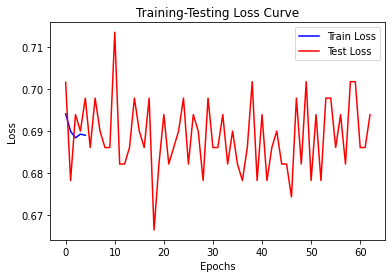

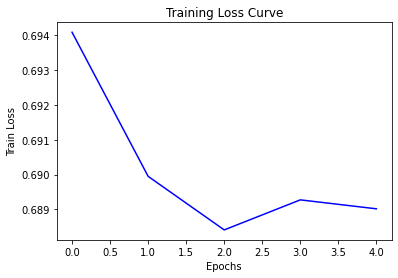

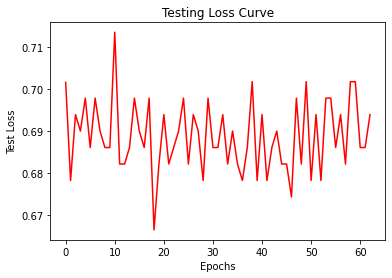

In [ ]:
plt.figure(6)
plt.plot(train_losses, 'b')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.figure(7)
plt.plot(test_run_losses, 'r')
plt.title("Testing Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")